<a href="https://colab.research.google.com/github/Yug-Oswal/Yug/blob/main/SarcasmDetector(kaggledata).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Checking current working directory
import os

os.getcwd()

'/content'

In [3]:
# Uploading the kaggle credentials and moving them to /root/.kaggle
# Importing libs
from google.colab import files
import shutil

uploaded = files.upload()

for fname in uploaded.keys():
  # Defining from path
  path = os.path.join(f'{os.getcwd()}', f'{fname}')
  # Defining /root/.kaggle path
  topath = os.path.join('/root', '.kaggle')
  # Defining final path destination
  final_path = os.path.join(topath, 'kaggle.json')
  # Remove directory if exists
  try:
    shutil.rmtree(final_path)
  except FileNotFoundError:
    pass
  # Create a new directory
  try:
    os.makedirs(topath)
  except FileExistsError:
    pass
  # Move file using shutil
  shutil.move(path, final_path)

# Verifying if file is successfully moved
os.listdir(topath)

Saving kaggle.json to kaggle.json


['kaggle.json']

In [4]:
# Changing user perms for kaggle.json
!chmod 600 "{final_path}"

# Importing kaggle
import kaggle

In [5]:
# Downloading the dataset from kaggle
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

100% 3.30M/3.30M [00:01<00:00, 3.56MB/s]
100% 3.30M/3.30M [00:01<00:00, 2.67MB/s]


In [6]:
# Importing zip libs
import zipfile
# Unzipping the dataset
zip_dataset = 'news-headlines-dataset-for-sarcasm-detection.zip'
zip_ref = zipfile.ZipFile(os.path.join('/content', zip_dataset))
# Unloading to /content/sarcasm.json
zip_ref.extractall('./sarcasm')
zip_ref.close()

In [7]:
# Verifying unzip
os.listdir('./sarcasm')

['Sarcasm_Headlines_Dataset.json', 'Sarcasm_Headlines_Dataset_v2.json']

In [8]:
# Defining path to sarcasm dataset
sarcasm_dataset_path = os.path.join(f"{os.getcwd()}", 'sarcasm', f"{os.listdir('./sarcasm')[0]}")

In [9]:
# Importing libs for loading json files
import json

# Loading the dataset json file into an object
training_data = []
with open(sarcasm_dataset_path, 'r') as f:
  lines = f.readlines()
  for line in lines:
    training_data.append(json.loads(line.strip('\n')))

# Verifying if data has been correctly parsed
print(training_data[:5])

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}, {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365', 'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse", 'is_sarcastic': 0}, {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697', 'headline': "mom starting to fear son's web series closest thing she will have to grandchild", 'is_sarcastic': 1}, {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302', 'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'is_sarcastic': 1}, {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-bi

In [10]:
# Dividing the json elements into sentences and labels lists
sentences = []
labels = []
for item in training_data:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [11]:
# Checking dataset shape
print(len(sentences))

26709


In [45]:
# Defining the hyperparameters
training_size = 20000
vocab_size = 10000
oov_tok = "<OOV>"
embedding_dim = 32
max_length = 32

In [13]:
# Splitting the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Splitting the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [46]:
# Importing libs and modules for text preprocessing and Neural Network
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [47]:
# Instantiating the tokenizer object
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

# Tokenizing on the training data
tokenizer.fit_on_texts(training_sentences)
# Converting to sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, padding = 'post', truncating = 'post', maxlen = max_length)

In [48]:
# Similarly, padding the testing texts
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, padding = 'post', truncating = 'post', maxlen = max_length)

In [49]:
# Generating the word-index and index-word dictionaries
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [50]:
# Importing libs
import numpy as np

In [51]:
# Converting to np arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [52]:
# Defining a Neural Network architecture
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                                    tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Dense(24, activation = 'relu'),
                                    tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [53]:
# Checking model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 32)            320000    
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                792       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Defining training params
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
num_epochs = 30

In [55]:
# Training the model on the dataset
history = model.fit(training_padded,
                    training_labels,
                    epochs = num_epochs,
                    validation_data = (testing_padded, testing_labels))

Epoch 1/30
625/625 [==============================] - 20s 28ms/step - loss: 0.5428 - accuracy: 0.7224 - val_loss: 0.3830 - val_accuracy: 0.8420
Epoch 2/30
625/625 [==============================] - 4s 7ms/step - loss: 0.3015 - accuracy: 0.8774 - val_loss: 0.3406 - val_accuracy: 0.8477
Epoch 3/30
625/625 [==============================] - 4s 7ms/step - loss: 0.2265 - accuracy: 0.9104 - val_loss: 0.3477 - val_accuracy: 0.8496
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1820 - accuracy: 0.9294 - val_loss: 0.3727 - val_accuracy: 0.8469
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1495 - accuracy: 0.9459 - val_loss: 0.3946 - val_accuracy: 0.8501
Epoch 6/30
625/625 [==============================] - 5s 8ms/step - loss: 0.1263 - accuracy: 0.9568 - val_loss: 0.4386 - val_accuracy: 0.8398
Epoch 7/30
625/625 [==============================] - 4s 7ms/step - loss: 0.1084 - accuracy: 0.9626 - val_loss: 0.4687 - val_accuracy: 0.8408
Epoc

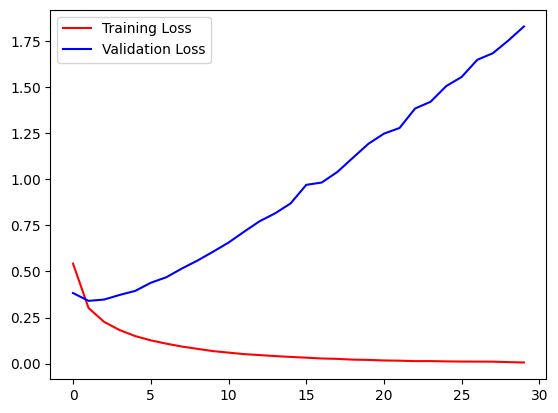

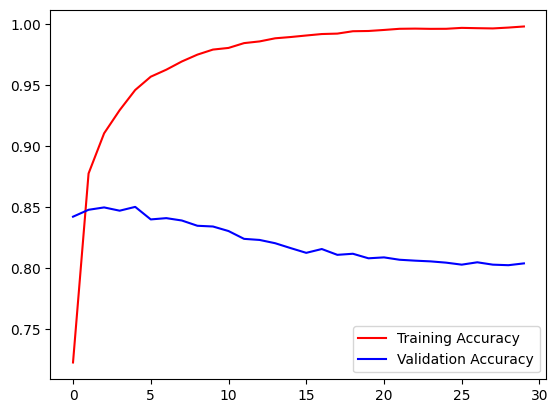

In [56]:
# Visualising the training data
hist = history.history

loss = hist['loss']
acc = hist['accuracy']
val_loss = hist['val_loss']
val_acc = hist['val_accuracy']
epochs = range(len(loss))

# Importing required libs
import matplotlib.pyplot as plt

plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.legend()
plt.show()

In [57]:
# Visualising word embeddings

# Getting the embedding layer
embedding_layer = model.layers[0]

# Getting the embedding weights
embedding_weights = embedding_layer.get_weights()[0]

# Checking the embedding shape
print(embedding_weights.shape)

(10000, 32)


In [58]:
# Writing tsv embedding files
import io

out_v = io.open('vecs.tsv', 'w')
out_m = io.open('meta.tsv', 'w')

for word_num in range(1, vocab_size):
  word = index_word[word_num]
  vec = embedding_weights[word_num]

  out_m.write(word + '\n')
  out_v.write('\t'.join([str(x) for x in vec]) + '\n')

out_m.close()
out_v.close()

In [59]:
# Downloading the files
files.download('vecs.tsv')
files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Projected Embeddings
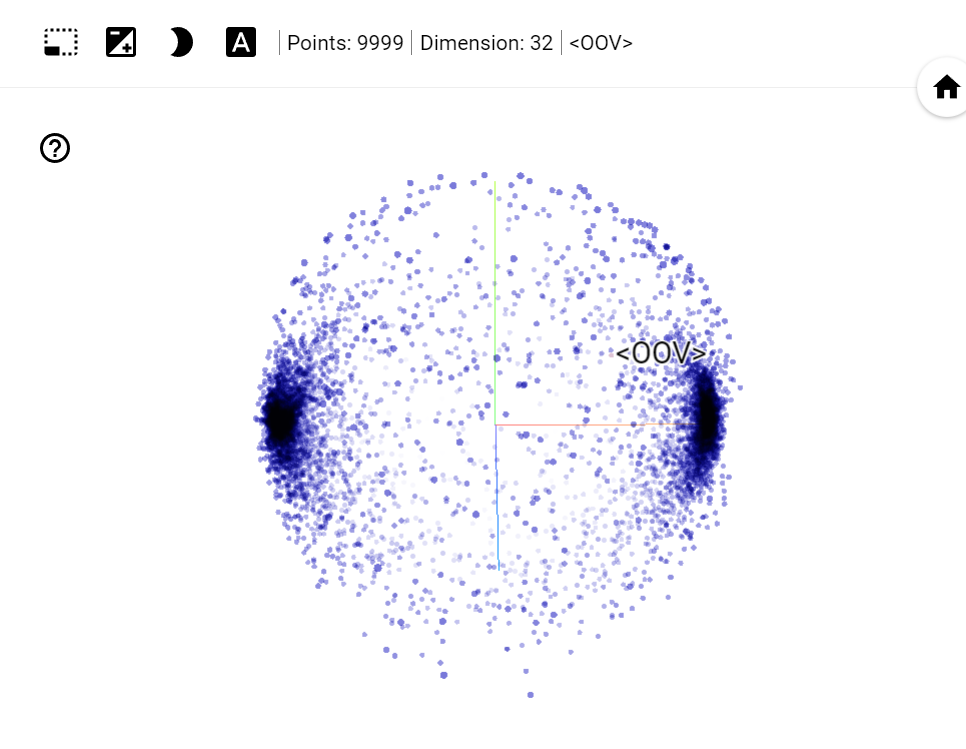
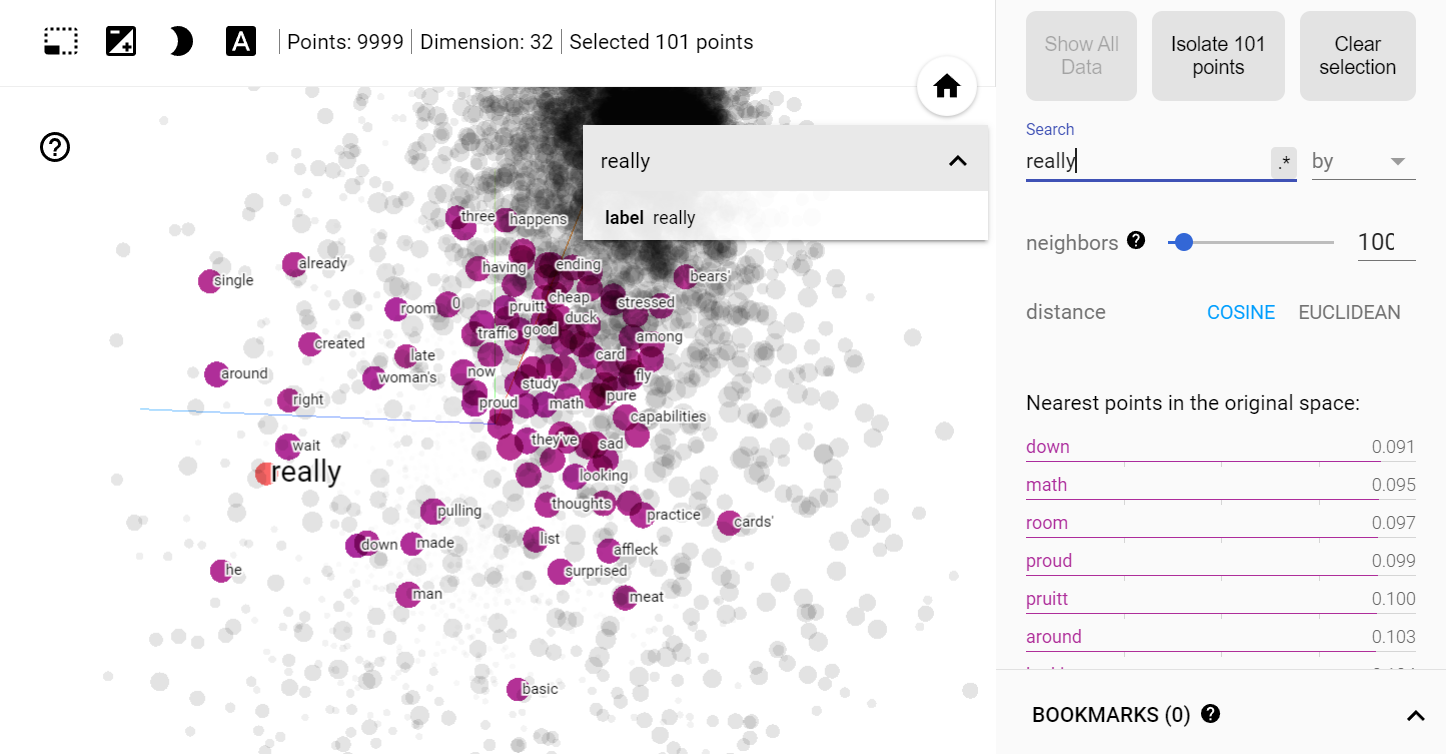